In [1]:
#to remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing all the important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline


In [3]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


#Now we will create Neural Network Model
The model will consist of input layer + 4 Hidden Layers + an output layer


In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16000, 512),   #input layer

            nn.Linear(512, 256),     #hidden1

            nn.Linear(256, 128),     #hidden2

            nn.Linear(128,64),      #hidden3

            nn.Linear(64,64),       #hidden4

            nn.Linear(64,35)        #output layer

        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [6]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16000, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Linear(in_features=64, out_features=35, bias=True)
  )
)


#Easy Peezy! Isn't it?

But what if the network goes too deep? Can you keep writing all the 40 layers?
 Feeling Dizzy?

#Let's try another way!

In [7]:
import torch
import torch.nn as nn

class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(DeepNeuralNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_hidden_layers = num_hidden_layers

        # Define the input layer
        self.input_layer = nn.Linear(input_size, hidden_size)

        # Define the hidden layers
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)])

        # Define the output layer
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Forward pass through the network

        # Input layer
        x = self.input_layer(x)

        # Hidden layers
        for layer in self.hidden_layers:
            x = layer(x)

        # Output layer
        x = self.output_layer(x)

        return x

# Define the input size, hidden size, output size, and number of hidden layers
input_size =  16000 # Define the size of your input features
hidden_size = 64  # Define the size of your hidden layers
output_size = 35 # Define the size of your output (e.g., number of classes for classification)
num_hidden_layers = 40  # Define the number of hidden layers

# Create an instance of the DeepNeuralNetwork model
model = DeepNeuralNetwork(input_size, hidden_size, output_size, num_hidden_layers)

# Print the model architecture
print(model)


DeepNeuralNetwork(
  (input_layer): Linear(in_features=16000, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0-39): 40 x Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=35, bias=True)
)


**Home Takeaway:** *Defining a function and writing modular code helps!*

#Let's see how the model works with the dataset

In [8]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

100%|██████████| 2.26G/2.26G [00:20<00:00, 121MB/s]


Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


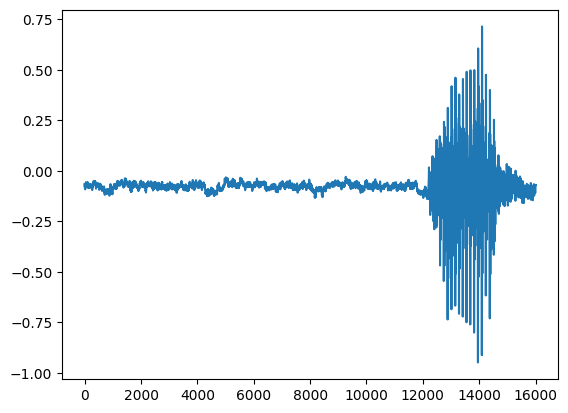

In [9]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [10]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [11]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [12]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets




In [13]:
batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [14]:
k = next(iter(train_loader))
print(k[0].shape)

torch.Size([256, 1, 16000])


In [15]:
model = NeuralNetwork()
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16000, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Linear(in_features=64, out_features=35, bias=True)
  )
)
Number of parameters: 8371427


Let's Add Optimizer as Well

In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001)

In [17]:
import torch.nn.functional as F

In [18]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [19]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        #data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [20]:
from tqdm import tqdm

  0%|          | 0.0026666666666666666/2 [00:00<09:49, 295.02s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 0.007241


  3%|▎         | 0.05599999999999999/2 [00:14<08:45, 270.11s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: -0.006928


  5%|▌         | 0.10933333333333328/2 [00:29<08:31, 270.35s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: -0.017124


  8%|▊         | 0.16266666666666676/2 [00:43<08:03, 263.37s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: -0.031765


 11%|█         | 0.21600000000000033/2 [00:57<07:47, 261.80s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: -0.033851


 13%|█▎        | 0.2693333333333337/2 [01:12<08:25, 292.13s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: -0.057970


 16%|█▌        | 0.3226666666666667/2 [01:26<07:19, 261.75s/it] 

Train Epoch: 1 [30720/84843 (36%)]	Loss: -0.065189


 19%|█▉        | 0.3759999999999997/2 [01:40<06:53, 254.57s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: -0.085110


 21%|██▏       | 0.42933333333333273/2 [01:54<06:39, 254.28s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: -0.091021


 24%|██▍       | 0.48266666666666574/2 [02:09<07:11, 284.31s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: -0.098853


 27%|██▋       | 0.5359999999999995/2 [02:23<06:29, 266.22s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: -0.121703


 29%|██▉       | 0.5893333333333336/2 [02:38<06:09, 262.19s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: -0.121458


 32%|███▏      | 0.6426666666666677/2 [02:52<06:50, 302.09s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: -0.148983


 35%|███▍      | 0.6960000000000018/2 [03:07<05:51, 269.34s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: -0.169124


 37%|███▋      | 0.749333333333336/2 [03:21<05:28, 262.54s/it] 

Train Epoch: 1 [71680/84843 (84%)]	Loss: -0.176950


 40%|████      | 0.8026666666666701/2 [03:35<05:13, 262.21s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: -0.201465


 43%|████▎     | 0.8560000000000042/2 [03:50<05:15, 275.71s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: -0.219773


 50%|█████     | 1.0000000000000062/2 [04:27<03:59, 239.20s/it]


Test Epoch: 1	Accuracy: 399/11005 (4%)



 50%|█████     | 1.0026666666666728/2 [04:27<04:06, 247.52s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: -0.226773


 53%|█████▎    | 1.0560000000000047/2 [04:42<04:10, 264.87s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: -0.245302


 55%|█████▌    | 1.1093333333333366/2 [04:57<04:17, 289.02s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: -0.262036


 58%|█████▊    | 1.1626666666666685/2 [05:11<03:46, 270.56s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: -0.292676


 61%|██████    | 1.2160000000000004/2 [05:26<03:28, 266.43s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: -0.314657


 63%|██████▎   | 1.2693333333333323/2 [05:41<03:39, 300.03s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: -0.364771


 66%|██████▌   | 1.3226666666666642/2 [05:56<03:03, 271.61s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: -0.380900


 69%|██████▉   | 1.3759999999999961/2 [06:10<02:46, 266.43s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: -0.426106


 71%|███████▏  | 1.429333333333328/2 [06:25<02:56, 309.77s/it] 

Train Epoch: 2 [40960/84843 (48%)]	Loss: -0.478628


 74%|███████▍  | 1.48266666666666/2 [06:40<02:22, 274.72s/it]  

Train Epoch: 2 [46080/84843 (54%)]	Loss: -0.523082


 77%|███████▋  | 1.5359999999999918/2 [06:55<02:04, 268.04s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: -0.600826


 79%|███████▉  | 1.5893333333333237/2 [07:09<01:49, 266.50s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: -0.702302


 82%|████████▏ | 1.6426666666666556/2 [07:24<01:40, 280.11s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: -0.805513


 85%|████████▍ | 1.6959999999999875/2 [07:39<01:21, 266.61s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: -0.973449


 87%|████████▋ | 1.7493333333333194/2 [07:53<01:06, 265.29s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: -1.230881


 90%|█████████ | 1.8026666666666513/2 [08:08<00:56, 285.76s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: -1.527339


 93%|█████████▎| 1.8559999999999832/2 [08:23<00:38, 269.53s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: -2.199042


100%|█████████▉| 1.9999999999999793/2 [09:00<00:00, 270.20s/it]


Test Epoch: 2	Accuracy: 420/11005 (4%)



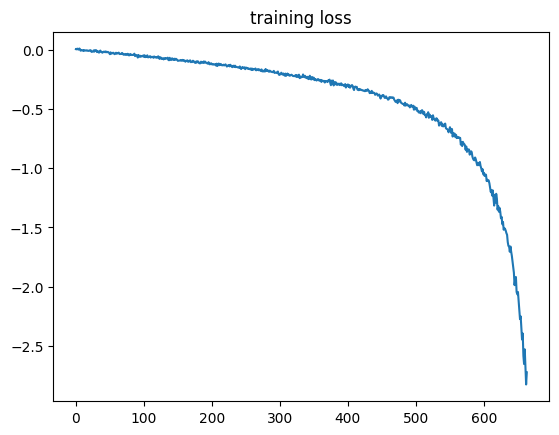

In [21]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)

#Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");

In [22]:
model = DeepNeuralNetwork(16000,64,35,40)
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

DeepNeuralNetwork(
  (input_layer): Linear(in_features=16000, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0-39): 40 x Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=35, bias=True)
)
Number of parameters: 1192739


In [23]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001)
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [24]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        #data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

  0%|          | 0.0026666666666666666/2 [00:00<07:37, 229.11s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 0.013756


  3%|▎         | 0.05599999999999999/2 [00:13<08:49, 272.27s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 0.006502


  5%|▌         | 0.10933333333333328/2 [00:25<07:51, 249.43s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: -0.020114


  8%|▊         | 0.16266666666666676/2 [00:38<07:15, 236.87s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: -0.038875


 11%|█         | 0.21600000000000033/2 [00:50<06:46, 228.09s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: -0.049319


 13%|█▎        | 0.2693333333333337/2 [01:03<06:33, 227.41s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: -0.067092


 16%|█▌        | 0.3226666666666667/2 [01:15<06:18, 225.51s/it] 

Train Epoch: 1 [30720/84843 (36%)]	Loss: -0.086549


 19%|█▉        | 0.3759999999999997/2 [01:28<06:06, 225.50s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: -0.106493


 21%|██▏       | 0.42933333333333273/2 [01:40<05:53, 225.21s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: -0.133291


 24%|██▍       | 0.48266666666666574/2 [01:52<05:38, 223.25s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: -0.158157


 27%|██▋       | 0.5359999999999995/2 [02:05<06:39, 272.65s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: -0.183512


 29%|██▉       | 0.5893333333333336/2 [02:18<05:55, 252.16s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: -0.203604


 32%|███▏      | 0.6426666666666677/2 [02:31<05:12, 230.52s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: -0.236796


 35%|███▍      | 0.6960000000000018/2 [02:43<05:00, 230.06s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: -0.293268


 37%|███▋      | 0.749333333333336/2 [02:55<04:42, 226.17s/it] 

Train Epoch: 1 [71680/84843 (84%)]	Loss: -0.317987


 40%|████      | 0.8026666666666701/2 [03:08<04:29, 224.75s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: -0.369654


 43%|████▎     | 0.8560000000000042/2 [03:20<04:14, 222.19s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: -0.432204


 50%|█████     | 1.0000000000000062/2 [03:53<03:38, 218.96s/it]


Test Epoch: 1	Accuracy: 425/11005 (4%)



 50%|█████     | 1.0026666666666728/2 [03:53<03:40, 221.47s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: -0.518348


 53%|█████▎    | 1.0560000000000047/2 [04:06<03:32, 224.79s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: -0.609383


 55%|█████▌    | 1.1093333333333366/2 [04:18<03:18, 222.80s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: -0.761733


 58%|█████▊    | 1.1626666666666685/2 [04:31<03:42, 265.49s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: -0.996998


 61%|██████    | 1.2160000000000004/2 [04:43<03:18, 253.46s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: -1.448343


 63%|██████▎   | 1.2693333333333323/2 [04:56<02:53, 237.90s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: -2.623606


 66%|██████▌   | 1.3226666666666642/2 [05:08<02:35, 229.17s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: -19.545326


 69%|██████▉   | 1.3759999999999961/2 [05:21<02:20, 225.86s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: nan


 71%|███████▏  | 1.429333333333328/2 [05:35<02:14, 235.14s/it] 

Train Epoch: 2 [40960/84843 (48%)]	Loss: nan


 74%|███████▍  | 1.48266666666666/2 [05:47<01:57, 227.43s/it]  

Train Epoch: 2 [46080/84843 (54%)]	Loss: nan


 77%|███████▋  | 1.5359999999999918/2 [06:00<01:44, 225.82s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: nan


 79%|███████▉  | 1.5893333333333237/2 [06:12<01:32, 225.68s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: nan


 82%|████████▏ | 1.6426666666666556/2 [06:25<01:36, 269.05s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: nan


 85%|████████▍ | 1.6959999999999875/2 [06:38<01:15, 247.32s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: nan


 87%|████████▋ | 1.7493333333333194/2 [06:51<00:58, 233.16s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: nan


 90%|█████████ | 1.8026666666666513/2 [07:03<00:44, 227.84s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: nan


 93%|█████████▎| 1.8559999999999832/2 [07:16<00:32, 228.77s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: nan


100%|█████████▉| 1.9999999999999793/2 [07:49<00:00, 234.55s/it]


Test Epoch: 2	Accuracy: 165/11005 (1%)



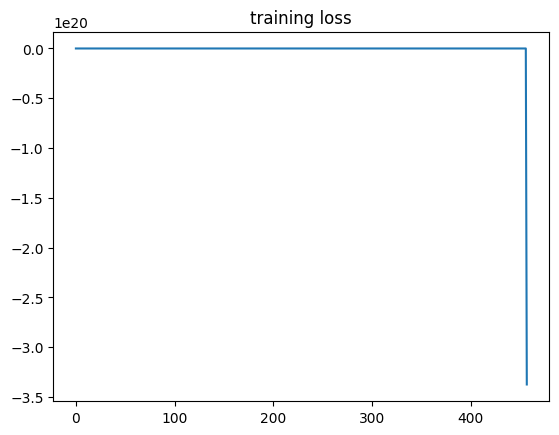

In [25]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)

#Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");

#What's missing? Any Guesses?

In [26]:
import torch
import torch.nn as nn

class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(DeepNeuralNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_hidden_layers = num_hidden_layers

        # Define the input layer
        self.input_layer = nn.Linear(input_size, hidden_size)

        # Define the hidden layers
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)])

        # Define the output layer
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Forward pass through the network

        # Input layer
        x = torch.relu(self.input_layer(x))

        # Hidden layers
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))

        # Output layer
        x = self.output_layer(x)

        return x

# Define the input size, hidden size, output size, and number of hidden layers
input_size =  16000 # Define the size of your input features
hidden_size = 128  # Define the size of your hidden layers
output_size = 35 # Define the size of your output (e.g., number of classes for classification)
num_hidden_layers = 40  # Define the number of hidden layers

# Create an instance of the DeepNeuralNetwork model
model = DeepNeuralNetwork(input_size, hidden_size, output_size, num_hidden_layers)

# Print the model architecture
print(model)


DeepNeuralNetwork(
  (input_layer): Linear(in_features=16000, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0-39): 40 x Linear(in_features=128, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=35, bias=True)
)


#Did you notice the difference? It was the activation function!

Non-Linearity! Key to Learn!

In [27]:
model = DeepNeuralNetwork(16000,64,35,40)
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

DeepNeuralNetwork(
  (input_layer): Linear(in_features=16000, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0-39): 40 x Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=35, bias=True)
)
Number of parameters: 1192739


In [28]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001)
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [29]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        #data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

  0%|          | 0.0026666666666666666/2 [00:00<07:32, 226.40s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: -0.015149


  3%|▎         | 0.05599999999999999/2 [00:13<07:19, 225.83s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: -0.029938


  5%|▌         | 0.10933333333333328/2 [00:25<07:04, 224.74s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: -0.044438


  8%|▊         | 0.16266666666666676/2 [00:38<06:54, 225.66s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: -0.048610


 11%|█         | 0.21600000000000033/2 [00:51<08:08, 273.72s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: -0.057208


 13%|█▎        | 0.2693333333333337/2 [01:03<07:08, 247.85s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: -0.060278


 16%|█▌        | 0.3226666666666667/2 [01:16<06:38, 237.64s/it] 

Train Epoch: 1 [30720/84843 (36%)]	Loss: -0.072432


 19%|█▉        | 0.3759999999999997/2 [01:29<06:15, 231.21s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: -0.076772


 21%|██▏       | 0.42933333333333273/2 [01:41<05:59, 228.98s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: -0.091207


 24%|██▍       | 0.48266666666666574/2 [01:54<05:46, 228.15s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: -0.100570


 27%|██▋       | 0.5359999999999995/2 [02:06<05:33, 227.79s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: -0.109662


 29%|██▉       | 0.5893333333333336/2 [02:19<05:17, 224.93s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: -0.120077


 32%|███▏      | 0.6426666666666677/2 [02:32<06:03, 267.91s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: -0.128309


 35%|███▍      | 0.6960000000000018/2 [02:45<05:19, 245.03s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: -0.144416


 37%|███▋      | 0.749333333333336/2 [02:57<04:51, 232.68s/it] 

Train Epoch: 1 [71680/84843 (84%)]	Loss: -0.159442


 40%|████      | 0.8026666666666701/2 [03:10<04:35, 229.80s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: -0.158424


 43%|████▎     | 0.8560000000000042/2 [03:22<04:20, 227.84s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: -0.172814


 50%|█████     | 1.0000000000000062/2 [03:55<03:42, 222.87s/it]


Test Epoch: 1	Accuracy: 419/11005 (4%)



 50%|█████     | 1.0026666666666728/2 [03:56<03:43, 223.74s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: -0.176394


 53%|█████▎    | 1.0560000000000047/2 [04:08<03:33, 226.07s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: -0.194175


 55%|█████▌    | 1.1093333333333366/2 [04:21<03:21, 226.13s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: -0.201127


 58%|█████▊    | 1.1626666666666685/2 [04:33<03:08, 225.28s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: -0.218889


 61%|██████    | 1.2160000000000004/2 [04:47<03:33, 272.51s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: -0.218078


 63%|██████▎   | 1.2693333333333323/2 [04:59<03:05, 253.79s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: -0.250212


 66%|██████▌   | 1.3226666666666642/2 [05:12<02:40, 236.39s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: -0.257632


 69%|██████▉   | 1.3759999999999961/2 [05:24<02:24, 231.91s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: -0.280317


 71%|███████▏  | 1.429333333333328/2 [05:37<02:09, 227.68s/it] 

Train Epoch: 2 [40960/84843 (48%)]	Loss: -0.316686


 74%|███████▍  | 1.48266666666666/2 [05:49<01:56, 225.45s/it]  

Train Epoch: 2 [46080/84843 (54%)]	Loss: -0.319302


 77%|███████▋  | 1.5359999999999918/2 [06:02<01:44, 224.33s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: -0.314348


 79%|███████▉  | 1.5893333333333237/2 [06:14<01:32, 225.71s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: -0.365619


 82%|████████▏ | 1.6426666666666556/2 [06:27<01:20, 226.50s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: -0.384068


 85%|████████▍ | 1.6959999999999875/2 [06:40<01:20, 263.61s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: -0.392689


 87%|████████▋ | 1.7493333333333194/2 [06:53<01:01, 243.59s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: -0.427145


 90%|█████████ | 1.8026666666666513/2 [07:05<00:45, 230.98s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: -0.451785


 93%|█████████▎| 1.8559999999999832/2 [07:17<00:33, 231.30s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: -0.499121


100%|█████████▉| 1.9999999999999793/2 [07:52<00:00, 236.32s/it]


Test Epoch: 2	Accuracy: 419/11005 (4%)



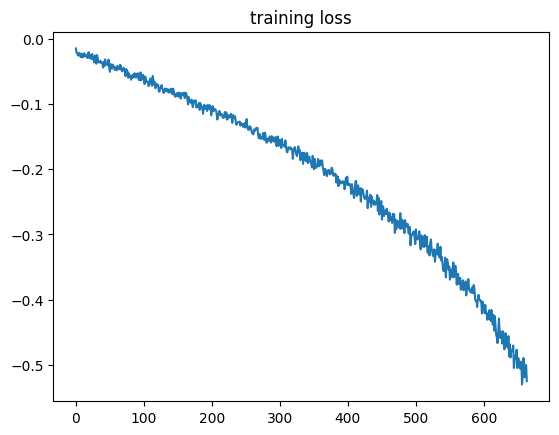

In [30]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)

#Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");

Let's change the batch size

In [31]:
batch_size = 1024

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [32]:
k = next(iter(train_loader))
print(k[0].shape)

torch.Size([1024, 1, 16000])


In [33]:
model = DeepNeuralNetwork(16000,64,35,40)
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

DeepNeuralNetwork(
  (input_layer): Linear(in_features=16000, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0-39): 40 x Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=35, bias=True)
)
Number of parameters: 1192739


In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [35]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        #data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

  1%|          | 0.010638297872340425/2 [00:02<08:07, 245.25s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 0.002083


 11%|█         | 0.22340425531914881/2 [00:53<07:03, 238.12s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: -7445198848.000000


 22%|██▏       | 0.4361702127659576/2 [01:44<06:14, 239.79s/it] 

Train Epoch: 1 [40960/84843 (48%)]	Loss: -834979260417506216509440.000000


 32%|███▏      | 0.6489361702127656/2 [02:35<05:20, 237.26s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: -2320404551932066505162752.000000


 43%|████▎     | 0.8617021276595733/2 [03:29<04:34, 241.56s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: -3183405929807012327063552.000000


 50%|████▉     | 0.9999999999999983/2 [04:01<03:49, 229.41s/it]


Test Epoch: 1	Accuracy: 400/11005 (4%)



 51%|█████     | 1.0106382978723387/2 [04:04<03:46, 228.77s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: -3691217700500878022148096.000000


 61%|██████    | 1.2234042553191486/2 [04:54<02:59, 230.82s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: -5619537139491812235280384.000000


 72%|███████▏  | 1.4361702127659586/2 [05:44<02:14, 237.80s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: -5978520002538236964503552.000000


 82%|████████▏ | 1.6489361702127685/2 [06:34<01:21, 231.01s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: -7272006849908255330664448.000000


 93%|█████████▎| 1.8617021276595784/2 [07:25<00:32, 236.56s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: -9313220939091044303110144.000000


100%|██████████| 2.000000000000005/2 [07:57<00:00, 238.61s/it]


Test Epoch: 2	Accuracy: 400/11005 (4%)



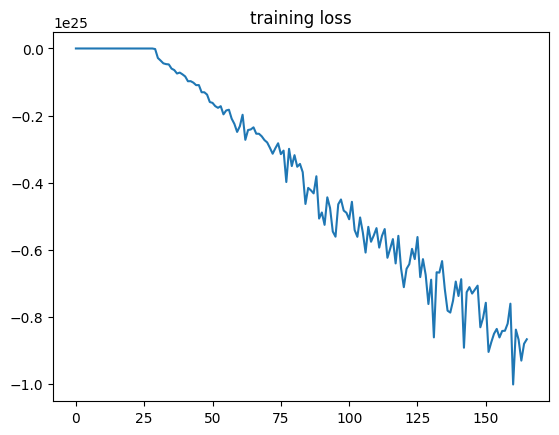

In [36]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)

#Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");